In [1]:
import numpy as np
import random
import scipy.integrate as scp
import numpy.random as rnd
import time
import matplotlib.pyplot as plt
import numpy.random as rnd
import copy
from matplotlib.pyplot import figure
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd
import pickle
import scipy.stats
from math import comb
from scipy.integrate import odeint

np.random.seed(1)

In [2]:
''' Data treatment'''
def save_pkl(item, fname):
    sn = 'tmp/' + fname
    with open(sn, 'wb') as handle:
        pickle.dump(item, handle) #, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'File saved at: {sn}')
    return None
# return None

def load_pkl(fname):
    with open(fname, 'rb') as handle:
        ans = pickle.load(handle)
    print(f'Loaded from: {fname}')
    return ans

# Data generation

In [3]:
xobs1 = load_pkl('data25/xobs1.pkl')
xobs2 = load_pkl('data25/xobs2.pkl')
xobs3 = load_pkl('data25/xobs3.pkl')
xobs4 = load_pkl('data25/xobs4.pkl')
mu_con   = load_pkl('data25/u_con.pkl')
tf_N  = load_pkl('data25/tf_N.pkl')
N_in  = load_pkl('data25/N_in.pkl')
operation_con = load_pkl('data25/operation_con.pkl')


tt1 = load_pkl('data25/tt1.pkl')
std_value1 = load_pkl('data25/std_value1.pkl')
std_value2 = load_pkl('data25/std_value2.pkl')
std_value3 = load_pkl('data25/std_value3.pkl')
std_value4 = load_pkl('data25/std_value4.pkl')
data_init = load_pkl('data25/data_init.pkl')

u_dic1    = load_pkl('data25/u_dic1.pkl')
u_dic2    = load_pkl('data25/u_dic2.pkl')
u_dic3    = load_pkl('data25/u_dic3.pkl')
u_dic4    = load_pkl('data25/u_dic4.pkl')

operation_con1 = operation_con[0]
operation_con2 = operation_con[1]
operation_con3 = operation_con[2]
operation_con4 = operation_con[3]

mu1 = mu_con[0] #u contains FNin and I0
mu2 = mu_con[1] 
mu3 = mu_con[2] 
mu4 = mu_con[3] 

tf    = 240
# tf    = 16*24
steps_= 24
dt    = tf/steps_ #dt is fixed





Loaded from: data25/xobs1.pkl
Loaded from: data25/xobs2.pkl
Loaded from: data25/xobs3.pkl
Loaded from: data25/xobs4.pkl
Loaded from: data25/u_con.pkl
Loaded from: data25/tf_N.pkl
Loaded from: data25/N_in.pkl
Loaded from: data25/operation_con.pkl
Loaded from: data25/tt1.pkl
Loaded from: data25/std_value1.pkl
Loaded from: data25/std_value2.pkl
Loaded from: data25/std_value3.pkl
Loaded from: data25/std_value4.pkl
Loaded from: data25/data_init.pkl
Loaded from: data25/u_dic1.pkl
Loaded from: data25/u_dic2.pkl
Loaded from: data25/u_dic3.pkl
Loaded from: data25/u_dic4.pkl


In [4]:
x_max = np.max(np.array([xobs1[0],xobs2[0],xobs3[0],xobs4[0]]))
q_max = np.max(np.array([xobs1[2],xobs2[2],xobs3[2],xobs4[2]]))
I_max = np.max(np.concatenate(mu_con).T[1])

# NN structure generation

In [10]:
def gen_NN(num_inputs,num_hiddenlayer,num_node,num_outputs):

    basic_structure = [num_inputs]

    for i in range(num_hiddenlayer):
        basic_structure.append(num_node)
    
    basic_structure.append(num_outputs)

    num_pairs = len(basic_structure)-1
    para_list = []
    for i in range(num_pairs):
        # next_layer_w = np.random.uniform(-0.01, 0.01,(basic_structure[i],basic_structure[i+1]))
        next_layer_w = np.random.normal(loc=0, scale=0.1, size=(basic_structure[i], basic_structure[i+1]))        
        next_layer_b = np.zeros([1,basic_structure[i+1]])
        para_list.append(next_layer_w)
        para_list.append(next_layer_b)

    # NNpara = np.concatenate([i.flatten() for i in para_list])
    
    return para_list

# def derivada_relu(x):
#     der_relu_x = np.zeros((x.shape[0],x.shape[1]))
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             if x[i][j]>0:
#                 der_relu_x[i][j] = 1
#             if x[i][j]<0:
#                 der_relu_x[i][j] = 0
#     return der_relu_x
def activation_func(x):
    return np.tanh(x)   

def NN_estimation(NN_structure,num_hiddenlayer,input):
    input = np.reshape(input, (1,len(input)))
    for i in range(num_hiddenlayer+1):
        if i < num_hiddenlayer:
            interal_cal = activation_func(input@NN_structure[2*i]+NN_structure[2*i+1])
            input       = interal_cal
        else:
            interal_cal = input@NN_structure[2*i]+NN_structure[2*i+1]
    return interal_cal


# Optimization algorithm (PSO+BFGS)

In [11]:
# == auxiliary functions == #

# sample uniform
def sample_uniform_params(n_particles_, bounds_range, bounds_bias):
    rand_particles = np.random.uniform(0,1,(n_particles_, bounds_range.shape[0]))*bounds_range + bounds_bias
    return rand_particles

# calculate velocity
def calculate_v(w_k, c1, c2, v_p, x_p, x_local_best, x_global_best):
    v_new = w_k*(c1*np.random.uniform(0,1, x_p.shape)*(x_local_best - x_p) + 
             c2*np.random.uniform(0,1, x_p.shape)*(x_global_best - x_p))
    return v_new

#################################################
# Particle Swarm optimization for policy search #
#################################################

def PSO(n_particles, evals, bounds,func):
    '''
    PSO algorithm used to find the best policy
    '''

    # problem initialization
    eval_count    = 0
    best_reward   = 1e9
    best_particle = np.zeros((bounds[:,0].shape))
    # algorithm parameters
    c1= 2.8;c2 = 1.3                     
    c3         = c1 + c2
    w_k        = 2/(abs(2 - c3 - np.sqrt((c3**2) - (4*c3))))  # creating velocity weighting factor
    # bounds
    bounds_range = bounds[:,1] - bounds[:,0]
    bounds_bias  = bounds[:,0]
    # velocity bounds
    v_lb                         = -abs(bounds_range)*0.75
    v_ub                         =  abs(bounds_range)*0.75

    # data
    data_pso = {}
    data_pso['R_list'] = np.zeros((evals))

    ############################
    # particle initializations #
    ############################

    # this can be changed manually

    particle_dic = {} # ['i'][particle, best_obj_p, best_position_p, vel]
    for particle_i in range(n_particles):

        # == sample a random particle == #
        particle_dic[str(particle_i)]                  = {}
        particle_dic[str(particle_i)]['particle_x']    = sample_uniform_params(1, bounds_range, bounds_bias)[0]
        particle_dic[str(particle_i)]['best_position'] = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])

        # == evaluate particle == #
        data_pso['R_list'][eval_count] = func(particle_dic[str(particle_i)]['particle_x'])
        
        # == set best particle objective == #
        particle_dic[str(particle_i)]['best_obj'] = data_pso['R_list'][eval_count]

        # == set particle velocity == #

        particle_dic[str(particle_i)]['vel'] = sample_uniform_params(1, v_ub-v_lb, v_lb)[0]

        # == benchmark reward ==> min ">"
        if data_pso['R_list'][eval_count] < best_reward:
            best_reward = data_pso['R_list'][eval_count]
            best_particle = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])

        eval_count     += 1

    #################
    # PSO main loop #
    #################

    while eval_count < evals:
        for particle_i in range(n_particles):

            # == calculate velocity == #
            particle_dic[str(particle_i)]['vel'] = calculate_v(w_k, c1, c2, 
                                                               particle_dic[str(particle_i)]['vel'], 
                                                               particle_dic[str(particle_i)]['particle_x'], 
                                                               particle_dic[str(particle_i)]['best_position'], 
                                                               best_particle)
            
            # == Update the particle's position == #
            particle_dic[str(particle_i)]['particle_x'] = (particle_dic[str(particle_i)]['particle_x'] + 
                                                           particle_dic[str(particle_i)]['vel'])
            
            # == evaluate particle == #
            data_pso['R_list'][eval_count]    = func(particle_dic[str(particle_i)]['particle_x'])

            # best position
            if data_pso['R_list'][eval_count] < particle_dic[str(particle_i)]['best_obj']:
                particle_dic[str(particle_i)]['best_obj']      = data_pso['R_list'][eval_count]
                particle_dic[str(particle_i)]['best_position'] = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])
                # best particle
                if data_pso['R_list'][eval_count] < best_reward:
                    best_reward   = data_pso['R_list'][eval_count]
                    best_particle = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])

            eval_count += 1
            if eval_count >= evals:
                break

    print('final reward = ',best_reward)
    return best_particle, best_reward, data_pso

######################################
# Forward finite differences 
######################################

def forward_finite_diff(f, x, Delta):
    n     = np.shape(x)[0]
    #x     = x.reshape((n,1))
    dX    = np.zeros((n))
    
    for j in range(n):
        x_d_f    = np.copy(x)
        x_d_f[j] = x_d_f[j] + Delta
        dX[j]    = (f(x_d_f) - f(x))/Delta

    #sumdX         = np.sum(dX)
    #array_has_nan = np.isnan(sumdX)
    #if array_has_nan:
    #    print('========= nan in gradient =========')

    return dX/np.max(dX)

######################################
# Central finite differences 
######################################

def central_finite_diff(f, x, Delta):
    n     = np.shape(x)[0]
    #x     = x.reshape((n,1))
    dX    = np.zeros((n))
    
    for j in range(n):
        x_d_f    = np.copy(x)
        x_d_b    = np.copy(x)
        x_d_f[j] = x_d_f[j] + Delta/2
        x_d_b[j] = x_d_b[j] - Delta/2
        dX[j]        = (f(x_d_f) - f(x_d_b))/Delta


    return dX/np.max(dX)

#############################
# Approximating Hessian
#############################

def Hk_f(x, x_past, grad_i, grad_i_past, Hk_past, Imatrix):
    '''
    function that approximates the Hessian
    '''
    sk  = x - x_past 
    yk  = grad_i - grad_i_past
    rho = 1./(yk.T@sk+1e-7)

    Hinv = (Imatrix-rho*sk@yk.T)@Hk_past@(Imatrix-rho*yk@sk.T) + rho*sk@sk.T
    
    return Hinv

#############################
# Line search function
#############################

def line_search_f(direction, x, f, lr, grad_k, armijo_wolfe=0):
    '''
    - function that determines optimal step with linesearch
    - Note: f and lr must be given
    - armijo_wolfe: 0 is naive, 1 is armijo, 2 is armijo-wolfe
    - for large iteration values (say >1000) A-W or A start being good options
    '''
    old_f = f(x) ; new_f = old_f + 1.
    ls_i  = 0    ; lr_i  = 2.*lr
    c_1   = 1e-4 ; c_2   = 0.9

    # if doing multistart this can be se to <10
    LS_max_iter = 50

    x_i   = x # if gradient is nan

    # ---  naive line-search --- #
    if armijo_wolfe == 0:
        while new_f>old_f and ls_i<LS_max_iter:
            lr_i  = lr_i/2.
            x_i   = x - lr_i*direction 
            new_f = f(x_i)
            ls_i += 1

    if new_f>old_f:
        return x, ls_i
        
    return x_i, ls_i


#############################
# Momentum function
#############################

def momentum_f(x, grad_i_past, grad_i, f, lr, Beta=0.2):
    '''
    function that determines the next step with momentum
    '''
    grad_m = Beta*grad_i_past + (1.-Beta)*grad_i
    old_f = f(x); new_f = old_f + 1.
    ls_i  = 0   ; lr_i  = 2.*lr
    while new_f>old_f and ls_i<100:
        lr_i  = lr_i/2.
        x_i   = x - lr_i*grad_m 
        new_f = f(x_i)
        ls_i += 1

    if new_f <= old_f:
        return x_i, ls_i, grad_m, new_f
    else:
        return x_i, ls_i, grad_m, old_f

###################################
# Gradient Descent with momentum
###################################

def gradient_descent_momentum(f, x0, N_x, max_iter=100, ns=5, grad_f=forward_finite_diff, 
                              lr=1e-3, grad_tol=1e-6):
    '''
    Optimization algorithm: Gradient Descent with linesearch
    '''

    # data
    data_gdm           = {}
    data_gdm['R_list'] = np.zeros((max_iter))

    # evaluate starting points
    data_gdm['x_best'] = x0; data_gdm['f_best'] = f(x0)
    f_eval              = 0    
    x                   = np.copy(x0);
    n                   = N_x

    # h-step
    Delta = np.sqrt(np.finfo(float).eps)#*1e1

    # ==== first gradient step ==== #
    grad_i      = grad_f(f, x, Delta)
    x           = x - 1e-6*grad_i
    # past values
    grad_i_past = grad_i
    f_val       = f(x)

    # ==== main loop ==== #
    while f_eval < max_iter:
        data_gdm['R_list'][f_eval] = f_val
    
        # compute gradient   
        grad_i  = grad_f(f, x, Delta)        
               
        # line-search w/momentum
        x_i, ls_i, grad_i_past, f_val = momentum_f(x, grad_i_past, grad_i, f, lr)
        f_eval                        = f_eval + 1

        if ls_i>50:
            print('50 LS could not reduce function further')
            break
        grad_best                               = grad_i
    
        x = x_i                

        if data_gdm['f_best'] > f_val:
            data_gdm['f_best'] = f_val
            data_gdm['x_best'] = x
            grad_best          = grad_i

    # print('f_eval   ===== ',f_eval)
    # print('x      ===== ',data_gdm['x_best']) 
    # print('grad ===== ',grad_best)
    # print('f(x) best ===== ',data_gdm['f_best'],'\n')
        
    return x, f_eval, data_gdm

# NN structure defination

In [16]:
num_inputs_      = 3
# num_hiddenlayer_ = 1
# num_nodes_       = 3
num_outputs_     = 1
# structure_infor = [num_layer,num_neu]
structure_infor = [1,10]
num_hiddenlayer_ = structure_infor[0]
num_nodes_       = structure_infor[1]

total_layer      = 2+num_hiddenlayer_ 
NN_structure_    = gen_NN(num_inputs_,num_hiddenlayer_ ,num_nodes_ ,num_outputs_)
no_NNpara_       = len(np.concatenate([i.flatten() for i in NN_structure_]))

# Hybrid model with NN

In [13]:
def hybrid_model(state,t, para,I_in, NN_structure_,num_hiddenlayer):

    #state vectors
    x = state[0]
    n = state[1]
    q = state[2]
    f = state[3]

    no_NNpara = len(np.concatenate([i.flatten() for i in NN_structure_]))

    NNx       = para[:no_NNpara]
    NNpara    = list(NNx).copy()

    shapes    = [i.shape for i in NN_structure_]
    sizes     = [i.size for i in NN_structure_]
    new_structure = []

    for i in range(len(shapes)):
        new_structure.append(np.array(NNpara [:sizes[i]]).reshape(shapes[i]))
        del NNpara[:sizes[i]]
    # Normalization of input for NN
    norm_x = x/x_max
    norm_q = q/q_max
    norm_I = I_in/I_max

    norm_input = np.array([norm_x,norm_q,norm_I])

    NN_output = NN_estimation(new_structure,num_hiddenlayer,norm_input)

    #mechanistic Parameters

    ud      = para[no_NNpara]
    un      = para[no_NNpara+1]
    kn      = para[no_NNpara+2]
    theta   = para[no_NNpara+3]
    gamma   = para[no_NNpara+4]
    epsilon = para[no_NNpara+5] 
    
    #algebraic equations
    
    u0     = NN_output 
    #variable rate equations
    dev_x  = u0*x-ud*x
    dev_n  = -un*(n/(n+kn))*x
    dev_q  = un*(n/(n+kn)) - (u0-ud)*q
    dev_f  = u0*(theta*q-epsilon*f) - gamma*un*(n/(n+kn))+ud*epsilon*f

    return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
    

# Simulation
def simulation(model, steps, tf, x0,para,I_in,NN_structure,num_hiddenlayer):
    t_eval        = np.linspace(0,tf,steps+1)
    sol           = odeint(model,x0, t_eval, args = (para,I_in,NN_structure,num_hiddenlayer)).T
        
    return sol,t_eval

# Objective function (BIC)

In [18]:
def pe_bic(para):
    no_NNpara_       = len(np.concatenate([i.flatten() for i in NN_structure_]))
    h_x01             = np.array([0.18,35,79.85,120])       
    h_xt1,htt_1       = simulation(hybrid_model,steps_, tf_,h_x01, para,I1,NN_structure_,num_hiddenlayer_)

    if np.isnan(np.sum(h_xt1)):

        return 1e7

    # if np.isnan(np.sum(h_xt1)):
    #     h_xt1 = np.full((xobs1.shape[0],xobs1.shape[1]), 1e4)

    # if np.isnan(np.sum(h_xt2)):
    #     h_xt2 = np.full((xobs2.shape[0],xobs2.shape[1]), 1e4)
    # if np.isnan(np.sum(h_xt3)):
    #     h_xt3 = np.full((xobs3.shape[0],xobs3.shape[1]), 1e4)



    # ----- nan correction ----- #


    # f   = 1/2*(np.sum(((h_xt1-xobs1)/std1)**2)+np.sum(((h_xt2-xobs2)/std2)**2)+np.sum(((h_xt3-xobs3)/std3)**2))
    
    f = 1/2*(np.sum(((h_xt1-xobs1)/std1)**2))
    nll = f+sigma1
    n_p = no_NNpara_
    BIC = (2*nll) + (n_p*np.log(nd1))
    return BIC
    # return f

# PSO+BFGS optimization for parameter estimation

In [19]:
bounds     = np.array([[-0.1,0.1]]*no_NNpara_+[[0,0.1],[0,5],[0,1],[0,10],[0,10],[0,0.1]])
dimensions = len(bounds)  

n_particles_ = 500
evals_       = 1000

best_particle_, best_reward_, data_pso_ = PSO(n_particles_, evals_, bounds,pe_bic)

# x, f_eval, data_gdm = gradient_descent_momentum(pe_bic, x0=best_particle_, N_x=bounds.shape[0], grad_f=central_finite_diff,args = (NN_structure_,num_hiddenlayer_))

C:\Users\wangh\AppData\Local\Temp\ipykernel_37796\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [16]:
# def PSO_NN_optimization(X):

#     num_hiddenlayer  = X[0]
#     num_nodes        = X[1]
    

#     NN_structure_    = gen_NN(num_inputs_,num_hiddenlayer,num_nodes ,num_outputs_)
#     no_NNpara_       = len(np.concatenate([i.flatten() for i in NN_structure_]))
#     bounds           = np.array([[-0.1,0.1]]*no_NNpara_+[[0,0.1],[0,5],[0,1],[0,10],[0,10],[0,0.1]])

#     n_particles_     = 50000
#     evals_           = 100000

#     best_particle_, best_reward_, data_pso_ = PSO(n_particles_, evals_, bounds,pe_bic)

#     x, f_eval, data_gdm = gradient_descent_momentum(pe_bic, x0=best_particle_, N_x=bounds.shape[0], grad_f=central_finite_diff)
#     save_pkl(opt,'hiddenlayer'+str(num_hiddenlayer)+'nodes'+str(num_nodes))
#     return opt_bic 
    

# Scipy optimization for paameter estimation

In [16]:
def NN_optimization(X):

    num_hiddenlayer  = int(X[0])
    num_nodes        = int(X[1])    

    NN_structure_    = gen_NN(num_inputs_,num_hiddenlayer,num_nodes ,num_outputs_)
    no_NNpara_       = len(np.concatenate([i.flatten() for i in NN_structure_]))
    bounds           = np.array([[-0.1,0.1]]*no_NNpara_+[[0,0.1],[0,5],[0,1],[0,10],[0,10],[0,0.1]])
    results = []
    est_pe  = []
    # add a if else here to compare with perious results
    for i in range(5):
        print(i)
        NN_initial = np.random.uniform(-0.05, 0.05,(1,no_NNpara_)).tolist()[0]
        kp_initial = [np.random.uniform(0, 0.1),np.random.uniform(0, 5),np.random.uniform(0, 1),np.random.uniform(0,10),np.random.uniform(0, 10),np.random.uniform(0, 0.1)]
        pe_initial = np.array(NN_initial+kp_initial)
        sol = scipy.optimize.minimize(pe_bic,pe_initial,method ='L-BFGS-B',tol=1e-12,bounds = bounds,args = (NN_structure_,num_hiddenlayer))
        results.append(sol.fun)
        est_pe.append(sol.x)
    df = pd.DataFrame(results,((x,) for x in est_pe))
    df = df.reset_index()
    df.columns = ['Parameters', 'BIC']
    opt = df[df['BIC'] == df['BIC'].min()]
    opt_bic = opt['BIC'].to_numpy()[0]
    save_pkl(opt,'hiddenlayer'+str(num_hiddenlayer)+'nodes'+str(num_nodes))
    return opt_bic 
    

# GA for NN structure optimization

0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2
3
4
File saved at: tmp/hiddenlayer1nodes1
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer1nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer1nodes3
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2
3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer1nodes3
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes3
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes1
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer1nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1
2


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3
4
File saved at: tmp/hiddenlayer2nodes3

Average time of function evaluating (secs): 570.7437638521194 (total = 5707.4376385211945)

Best score before optimization: 2973.7181804094616
|||||||_____________ 33.3% GA is running...1 gen from 3...best value = 2973.71818040946160


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1
2


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3
4
File saved at: tmp/hiddenlayer2nodes1
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1
2


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer1nodes1
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer1nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes2
|||||||||||||_______ 66.7% GA is running...2 gen from 3...best value = 2973.71818040946160


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer1nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1
2


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')
c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1
2
3
4
File saved at: tmp/hiddenlayer2nodes2
0


C:\Users\wangh\AppData\Local\Temp\ipykernel_8340\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2
3
4
File saved at: tmp/hiddenlayer2nodes2
                                                                                                                                                                                                        
 The best found solution:
 [1. 2.]

 Objective function:
 1080.2601056288954

 Used generations: 3
 Used time: 1.42e+04 seconds


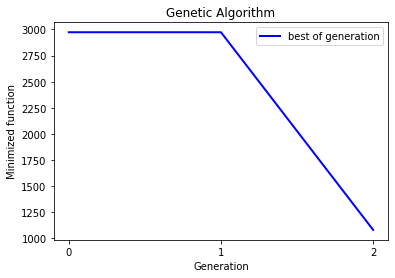

In [18]:
structure_bounds = [[1,2],[1,3]]
vartype = ( 'int', 'int')
dimensions = len(structure_bounds) 
algorithm_param = AlgorithmParams(
            max_num_iteration = 3,
            population_size = 10,
            mutation_probability = 0.1,
            mutation_discrete_probability = None,
            elit_ratio = 0.01,
            parents_portion = 0.3,
            crossover_type = 'uniform',
            mutation_type = 'uniform_by_center',
            mutation_discrete_type = 'uniform_discrete',
            selection_type = 'roulette',
            max_iteration_without_improv = None
        )
model = ga(function=NN_optimization,function_timeout = 400000, dimension=dimensions, variable_type=vartype, variable_boundaries=structure_bounds,algorithm_parameters=algorithm_param)
model.run()
obj_value = model.result.score
opt_pe    = model.result.variable
#

### Until here we get the optimum NN structure. However, because I seperated the NN structure optimization and PE for a certain structure, I cannot return PE result directly. Instead, I saved all PE results as pickl file so I can mannualy find it later based on the optimum NN structure.

# Check results

In [40]:
# Results from the whole algorithm
pe                = load_pkl('tmp/hiddenlayer1nodes2')
pe                = list(pe['Parameters'])[0][0]
num_hiddenlayer_  = 1
num_node_         = 2
NN_structure_     = gen_NN(num_inputs_,num_hiddenlayer_,num_node_,num_outputs_)
h_x01             = np.array([0.18,35,79.85,120])       
h_xt1,htt_1       = simulation(hybrid_model,steps_, tf_,h_x01,pe,I1,NN_structure_,num_hiddenlayer_)

Loaded from: tmp/hiddenlayer1nodes2


C:\Users\wangh\AppData\Local\Temp\ipykernel_14268\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


In [41]:
pe_bic(pe,NN_structure_,num_hiddenlayer_)

C:\Users\wangh\AppData\Local\Temp\ipykernel_14268\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


1080.2601546390968

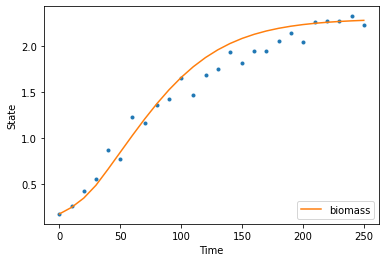

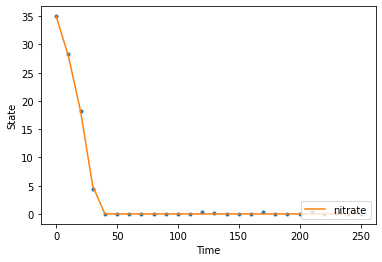

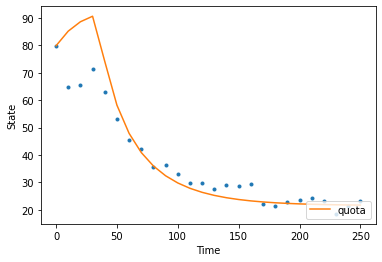

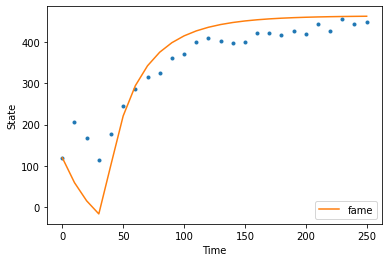

In [32]:
check_plot(xobs1,h_xt1,tt1)

In [38]:
# Results for 1 layer 3 nodes
pe                = load_pkl('tmp/pe for scipyopt')
# pe                = list(pe['Parameters'])[0][0]
num_hiddenlayer_  = 1
num_node_         = 3
NN_structure_     = gen_NN(num_inputs_,num_hiddenlayer_,num_node_,num_outputs_)
h_x01             = np.array([0.18,35,79.85,120])       
h_xt1,htt_1       = simulation(hybrid_model,steps_, tf_,h_x01,pe,I1,NN_structure_,num_hiddenlayer_)

Loaded from: tmp/pe for scipyopt


C:\Users\wangh\AppData\Local\Temp\ipykernel_14268\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


In [39]:
pe_bic(pe,NN_structure_,num_hiddenlayer_)

C:\Users\wangh\AppData\Local\Temp\ipykernel_14268\3381388352.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64')


880.447244345817

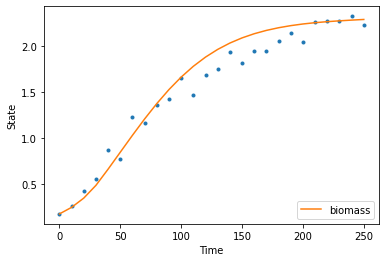

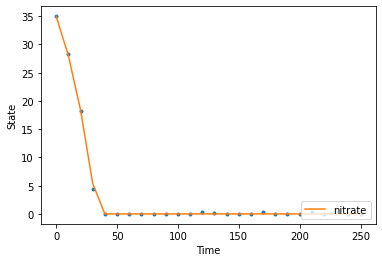

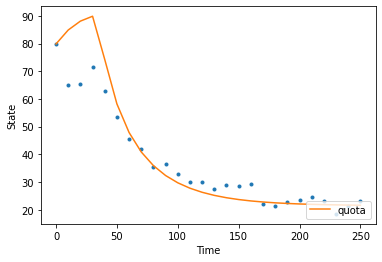

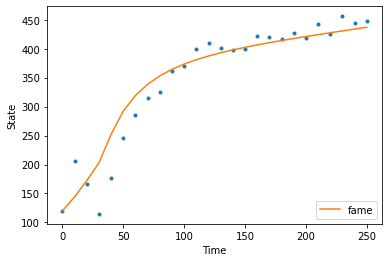

In [37]:
check_plot(xobs1,h_xt1,tt1)